In [50]:
%matplotlib inline
import glob
from collections import Counter
from itertools import chain
from copy import copy
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from joblib import Parallel, delayed
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest, VarianceThreshold
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold
from sklearn.cluster import FeatureAgglomeration
from sklearn.metrics import roc_curve, roc_auc_score, pairwise_distances
from sklearn.utils import resample


np.random.seed(42)
sns.set(style='white', context='paper', font_scale=2.5, rc={'figure.figsize': (12, 9)}, palette='deep')

In [2]:
def load_clinical_data(target_outcome='PR P'):
    """Load and preprocess the data."""
    data = pd.read_csv('data/clinical.csv', index_col='Study ID')
    outcomes = (pd.read_csv('data/clinical_outcomes.csv', usecols=['ID', target_outcome])
                .rename(columns={'ID': 'Study ID'})
                .set_index('Study ID'))
    data['target'] = outcomes[target_outcome]
    data = data.dropna(subset=['target'])
    data = data.drop(['cancer_death', 'split', 'target_binary', 'survival_time', 'death'],
                     axis=1, errors='ignore')

    # binarize T stage as T1/2 = 0, T3/4 = 1
    data['T Stage'] = data['T Stage'].map(
        lambda x: 'T1/2' if x in ['T1', 'T1a', 'T1b', 'T2'] else 'T3/4',
        na_action='ignore')
    # binarize N stage as N0/N+
    data['N Stage'] = data['N Stage'].map(
        lambda x: 'N0' if x == 'N0' else 'N+')
    data['Stage'] = data['Stage'].map(
        lambda x: 'I/II' if x in ['I', 'II', 'IIA'] else 'III/IV',
        na_action='ignore')
    data['ECOG'] = data['ECOG'].map(
        lambda x: '>0' if x > 0 else '0', na_action='ignore')
    data = pd.get_dummies(data,
                          columns=[
                              'Sex',
                              'N Stage',
                              'Disease Site',
                              'T Stage',
                              'Stage',
                              'ECOG',
                          ],
                          drop_first=True)
    # keep all indicator columns in case of missing values
    data = pd.get_dummies(data.rename(columns={'HPV Combined': 'HPV Status'}),
                          columns=[
                              'HPV Status',
                          ])
    return data


In [3]:
clinical = load_clinical_data('PR P')
clinical.describe()

,age at dx,Dose,Chemotherapy,volume,target,Sex_Male,N Stage_N0,Disease Site_larynx,Disease Site_lip & oral cavity,Disease Site_nasopharynx,Disease Site_oropharynx,T Stage_T3/4,Stage_III/IV,ECOG_>0,HPV Status_0.0,HPV Status_1.0
count,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000,290.000000
mean,59.489655,69.434483,0.796552,20631.415086,0.120690,0.744828,0.331034,0.286207,0.100000,0.055172,0.448276,0.620690,0.858621,0.724138,0.062069,0.100000
std,8.683291,2.789783,0.403259,18856.659383,0.326329,0.436712,0.471399,0.452769,0.300519,0.228711,0.498177,0.486054,0.349015,0.447720,0.241698,0.300519
min,20.000000,50.000000,0.000000,260.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,70.000000,1.000000,6795.770833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,60.000000,70.000000,1.000000,13775.625000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,65.000000,70.000000,1.000000,29615.604167,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,81.000000,72.000000,1.000000,91326.583333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
clinical.columns

Index(['age at dx', 'Dose', 'Chemotherapy', 'volume', 'target', 'Sex_Male',
       'N Stage_N0', 'Disease Site_larynx', 'Disease Site_lip & oral cavity',
       'Disease Site_nasopharynx', 'Disease Site_oropharynx', 'T Stage_T3/4',
       'Stage_III/IV', 'ECOG_>0', 'HPV Status_0.0', 'HPV Status_1.0'],
      dtype='object')

In [5]:
clinical['target'].sum()

35.0

In [6]:
X_clinical = clinical.drop('target', axis=1)
statistics, pvals = f_classif(X_clinical, clinical['target'])

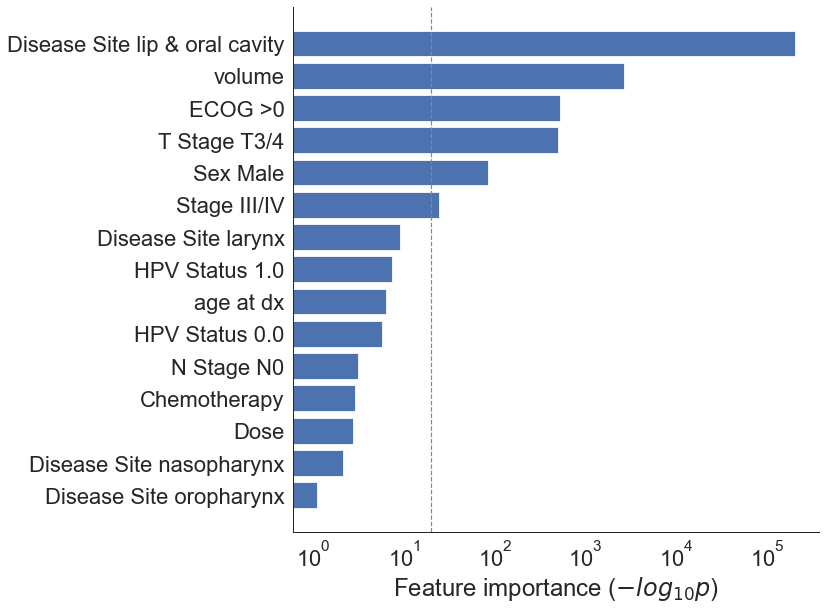

In [7]:
sort_idxs = np.argsort(pvals)[::-1]
fig, ax = plt.subplots()
yticks = np.arange(len(pvals))
ax.barh(yticks, 1 / pvals[sort_idxs])
ax.axvline(1 / .05, ls='--', c='#888888')
ax.set_yticks(yticks)
ax.set_yticklabels(X_clinical.columns[sort_idxs].map(lambda x: x.replace('_', ' ')))
ax.set_xlabel('Feature importance ($-log_{10}p$)')
ax.set_xscale('log')
fig.tight_layout()
sns.despine()

In [8]:
pvals[sort_idxs]

array([9.10820810e-01, 4.64029617e-01, 3.59539043e-01, 3.44031639e-01,
       3.23541456e-01, 1.73303568e-01, 1.57577579e-01, 1.33981049e-01,
       1.09875243e-01, 4.12236694e-02, 1.19960052e-02, 2.02448003e-03,
       1.93653987e-03, 3.79825834e-04, 4.90767556e-06])

In [9]:
num_folds = 5
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegressionCV(penalty='l1',
                         scoring='roc_auc', 
                         solver='liblinear', 
                         max_iter=500, 
                         cv=num_folds))
results_clinical = cross_validate(
    pipeline, X_clinical, clinical['target'], cv=num_folds, scoring='roc_auc', return_estimator=True)

In [10]:
results_clinical['test_score'].mean(), results_clinical['test_score'].std()

(0.7820728291316527, 0.05564015246133392)

In [11]:
selected = [(x[1].coef_ > 0).ravel() for x in results_clinical['estimator']]
num_selected = [x.sum() for x in selected]
names_selected = [X_clinical.columns[x].tolist() for x in selected]

In [12]:
np.mean(num_selected)

5.8

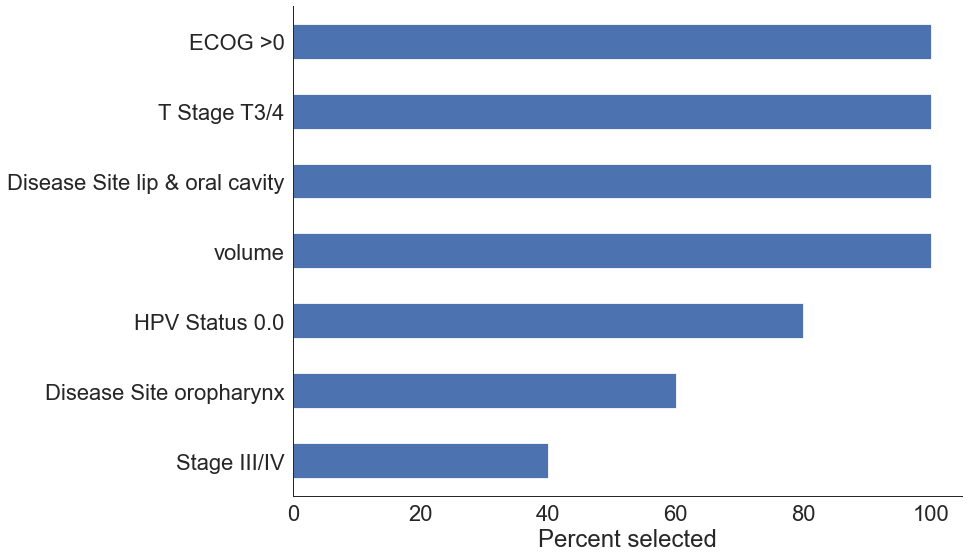

In [13]:
top_features = Counter(chain.from_iterable(names_selected)).most_common()
percent_selected = pd.Series(dict(top_features)) / num_folds * 100
percent_selected.index = percent_selected.index.map(lambda x: x.replace('_', ' '))
ax = percent_selected.sort_values().plot(kind='barh')
ax.set_xlabel('Percent selected')
sns.despine()

In [14]:
percent_selected.index.map(lambda x: x.replace('_', ' '))

Index(['volume', 'Disease Site lip & oral cavity', 'T Stage T3/4', 'ECOG >0',
       'HPV Status 0.0', 'Disease Site oropharynx', 'Stage III/IV'],
      dtype='object')

In [15]:
def load_radiomics(data_dir):
    radiomics_files = f'{data_dir}/*.csv'
    feature_classes = ['shape',
       'firstorder', 'glcm', 'gldm', 'glrlm', 'glszm', 'ngtdm']
    dfs = []
    for f in glob.iglob(radiomics_files):
        spacing = f.replace('.csv', '').split('_')[-1]
        df = pd.read_csv(f, index_col='Study ID').filter(regex='|'.join(feature_classes))
        new_colnames = {c: c + f'_{spacing}' for c in df.columns}
        df = df.rename(columns=new_colnames)
        dfs.append(df)
    return pd.concat(dfs, axis=1)

In [22]:
radiomics = load_radiomics('data/features_resegment_new/')

In [23]:
len(radiomics.columns)

3748

In [24]:
len([c for c in radiomics.columns if '1x1' in c])

1874

In [25]:
X_combined = pd.concat([X_clinical, radiomics], join='inner', axis=1)

In [26]:
X_combined.shape

(290, 3763)

In [27]:
correlation_thresh = .9

radiomics_preprocessing = make_pipeline(
    VarianceThreshold(1e-6),
    FeatureAgglomeration(affinity=partial(pairwise_distances, metric='correlation', n_jobs=1), 
                         n_clusters=None, distance_threshold=1 - correlation_thresh,
                         linkage="single"),
    StandardScaler(),

    SelectKBest(mutual_info_classif, k='all')
)

clinical_columns = X_clinical.columns.tolist()
preprocessing = make_column_transformer(
    (StandardScaler(), clinical_columns),
    remainder=radiomics_preprocessing,
)

pipeline = make_pipeline(
    preprocessing,
    LogisticRegression(penalty='l1',
                       solver='liblinear',
                       class_weight='balanced',
                       max_iter=500))
param_grid = {
    'columntransformer__remainder__selectkbest__k': np.arange(2, np.ceil(np.sqrt(len(X_combined))), 2, dtype=int),
    'logisticregression__C': np.logspace(-2, 2, 5),
}
num_folds = 5
estimator = GridSearchCV(pipeline, param_grid, cv=num_folds, scoring='roc_auc', n_jobs=14, verbose=10)
results_radiomics = cross_validate(
    estimator, X_combined, clinical.loc[X_combined.index, 'target'].values, cv=num_folds, return_estimator=True, scoring='roc_auc', verbose=10)

[CV]  ................................................................
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed:    7.4s
[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed:    7.8s
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:   14.0s
[Parallel(n_jobs=14)]: Done  33 tasks      | elapsed:   19.9s
[Parallel(n_jobs=14)]: Done  44 tasks      | elapsed:   24.0s
[Parallel(n_jobs=14)]: Done  57 tasks      | elapsed:   27.2s
[Parallel(n_jobs=14)]: Done  70 tasks      | elapsed:   31.7s
[Parallel(n_jobs=14)]: Done  85 tasks      | elapsed:   37.5s
[Parallel(n_jobs=14)]: Done 100 tasks      | elapsed:   43.0s
[Parallel(n_jobs=14)]: Done 117 tasks      | elapsed:   49.2s
[Parallel(n_jobs=14)]: Done 134 tasks      | elapsed:   56.4s
[Parallel(n_jobs=14)]: Done 153 tasks      | elapsed:  1.1min
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:  1.2min
[Parallel(n_jobs=14)]: Done 194 out 

[CV] .................................... , score=0.728, total= 1.4min
[CV]  ................................................................
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed:    5.8s
[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed:    6.2s
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:   11.8s
[Parallel(n_jobs=14)]: Done  33 tasks      | elapsed:   17.3s
[Parallel(n_jobs=14)]: Done  44 tasks      | elapsed:   21.6s
[Parallel(n_jobs=14)]: Done  57 tasks      | elapsed:   24.8s
[Parallel(n_jobs=14)]: Done  70 tasks      | elapsed:   29.2s
[Parallel(n_jobs=14)]: Done  85 tasks      | elapsed:   35.0s
[Parallel(n_jobs=14)]: Done 100 tasks      | elapsed:   40.7s
[Parallel(n_jobs=14)]: Done 117 tasks      | elapsed:   46.9s
[Parallel(n_jobs=14)]: Done 134 tasks      | elapsed:   53.6s
[Parallel(n_jobs=14)]: Done 153 tasks      | elapsed:  1.0min
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:  1.1min
[Parallel(n_jobs=14)]: Done 194 out o

[CV] .................................... , score=0.838, total= 1.3min
[CV]  ................................................................
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min remaining:    0.0s
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed:    6.2s
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:   12.0s
[Parallel(n_jobs=14)]: Done  33 tasks      | elapsed:   17.5s
[Parallel(n_jobs=14)]: Done  44 tasks      | elapsed:   21.8s
[Parallel(n_jobs=14)]: Done  57 tasks      | elapsed:   24.7s
[Parallel(n_jobs=14)]: Done  70 tasks      | elapsed:   29.6s
[Parallel(n_jobs=14)]: Done  85 tasks      | elapsed:   35.4s
[Parallel(n_jobs=14)]: Done 100 tasks      | elapsed:   41.2s
[Parallel(n_jobs=14)]: Done 117 tasks      | elapsed:   48.2s
[Parallel(n_jobs=14)]: Done 134 tasks      | elapsed:   55.5s
[Parallel(n_jobs=14)]: Done 153 tasks      | elapsed:  1.0min
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:  1.2min
[Parallel(n_jobs=14)]: Done 194 out o

[CV] .................................... , score=0.731, total= 1.3min
[CV]  ................................................................
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed:    6.3s
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:   12.0s
[Parallel(n_jobs=14)]: Done  33 tasks      | elapsed:   17.7s
[Parallel(n_jobs=14)]: Done  44 tasks      | elapsed:   21.9s
[Parallel(n_jobs=14)]: Done  57 tasks      | elapsed:   25.0s
[Parallel(n_jobs=14)]: Done  70 tasks      | elapsed:   29.7s
[Parallel(n_jobs=14)]: Done  85 tasks      | elapsed:   35.8s
[Parallel(n_jobs=14)]: Done 100 tasks      | elapsed:   41.3s
[Parallel(n_jobs=14)]: Done 117 tasks      | elapsed:   48.5s
[Parallel(n_jobs=14)]: Done 134 tasks      | elapsed:   56.2s
[Parallel(n_jobs=14)]: Done 153 tasks      | elapsed:  1.1min
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:  1.2min
[Parallel(n_jobs=14)]: Done 194 out o

[CV] .................................... , score=0.770, total= 1.4min
[CV]  ................................................................
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.4min remaining:    0.0s
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed:    6.2s
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:   12.0s
[Parallel(n_jobs=14)]: Done  33 tasks      | elapsed:   17.6s
[Parallel(n_jobs=14)]: Done  44 tasks      | elapsed:   22.6s
[Parallel(n_jobs=14)]: Done  57 tasks      | elapsed:   25.5s
[Parallel(n_jobs=14)]: Done  70 tasks      | elapsed:   29.8s
[Parallel(n_jobs=14)]: Done  85 tasks      | elapsed:   35.7s
[Parallel(n_jobs=14)]: Done 100 tasks      | elapsed:   42.0s
[Parallel(n_jobs=14)]: Done 117 tasks      | elapsed:   51.1s
[Parallel(n_jobs=14)]: Done 134 tasks      | elapsed:   58.7s
[Parallel(n_jobs=14)]: Done 153 tasks      | elapsed:  1.1min
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:  1.2min
[Parallel(n_jobs=14)]: Done 194 out o

[CV] .................................... , score=0.804, total= 1.4min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.8min finished


In [28]:
results_radiomics['test_score'].mean(), results_radiomics['test_score'].std()

(0.7742296918767506, 0.04213242728731243)

In [29]:
radiomics_contrast = load_radiomics('data/features_resegment_contrast/')

In [30]:
len(radiomics_contrast.columns)

3190

In [31]:
len([c for c in radiomics_contrast.columns if '1x1' in c])

1595

In [32]:
X_combined_contrast = pd.concat([X_clinical, radiomics_contrast], join='inner', axis=1)

In [33]:
X_combined_contrast.shape

(195, 3205)

In [34]:
correlation_thresh = .9

radiomics_preprocessing = make_pipeline(
    VarianceThreshold(1e-6),
    FeatureAgglomeration(affinity=partial(pairwise_distances, metric='correlation', n_jobs=1), 
                         n_clusters=None, distance_threshold=1 - correlation_thresh,
                         linkage="single"),
    StandardScaler(),

    SelectKBest(mutual_info_classif, k='all')
)

clinical_columns = X_clinical.columns.tolist()
preprocessing = make_column_transformer(
    (StandardScaler(), clinical_columns),
    remainder=radiomics_preprocessing,
)

pipeline = make_pipeline(
    preprocessing,
    LogisticRegression(penalty='l1',
                       solver='liblinear',
                       class_weight='balanced',
                       max_iter=500))
param_grid = {
    'columntransformer__remainder__selectkbest__k': np.arange(2, np.ceil(np.sqrt(len(X_combined_contrast))), 2, dtype=int),
    'logisticregression__C': np.logspace(-2, 2, 5),
}
num_folds = 5
estimator = GridSearchCV(pipeline, param_grid, cv=num_folds, scoring='roc_auc', n_jobs=14, verbose=10)
results_radiomics_contrast = cross_validate(
    estimator, X_combined_contrast, clinical.loc[X_combined_contrast.index, 'target'].values, cv=num_folds, return_estimator=True, scoring='roc_auc', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.


[CV]  ................................................................
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed:    4.1s
[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed:    4.3s
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    8.2s
[Parallel(n_jobs=14)]: Done  33 tasks      | elapsed:   11.6s
[Parallel(n_jobs=14)]: Done  44 tasks      | elapsed:   13.9s
[Parallel(n_jobs=14)]: Done  57 tasks      | elapsed:   17.0s
[Parallel(n_jobs=14)]: Done  70 tasks      | elapsed:   19.4s
[Parallel(n_jobs=14)]: Done  85 tasks      | elapsed:   23.7s
[Parallel(n_jobs=14)]: Done 100 tasks      | elapsed:   27.2s
[Parallel(n_jobs=14)]: Done 117 tasks      | elapsed:   31.9s
[Parallel(n_jobs=14)]: Done 139 out of 150 | elapsed:   37.0s remaining:    2.9s
[Parallel(n_jobs=14)]: Done 150 out of 150 | elapsed:   39.0s finished


[CV] .................................... , score=0.794, total=  41.0s
[CV]  ................................................................
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.0s remaining:    0.0s
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed:    3.5s
[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed:    3.8s
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    7.3s
[Parallel(n_jobs=14)]: Done  33 tasks      | elapsed:   10.3s
[Parallel(n_jobs=14)]: Done  44 tasks      | elapsed:   13.4s
[Parallel(n_jobs=14)]: Done  57 tasks      | elapsed:   15.9s
[Parallel(n_jobs=14)]: Done  70 tasks      | elapsed:   18.0s
[Parallel(n_jobs=14)]: Done  85 tasks      | elapsed:   22.4s
[Parallel(n_jobs=14)]: Done 100 tasks      | elapsed:   26.0s
[Parallel(n_jobs=14)]: Done 117 tasks      | elapsed:   29.9s
[Parallel(n_jobs=14)]: Done 139 out of 150 | elapsed:   34.8s remaining:    2.8s
[Parallel(n_jobs=14)]: Done 150 out of 150 | elapsed:   36.8s finished


[CV] .................................... , score=0.782, total=  38.9s
[CV]  ................................................................
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed:    3.5s
[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed:    3.8s
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    7.3s
[Parallel(n_jobs=14)]: Done  33 tasks      | elapsed:   10.5s
[Parallel(n_jobs=14)]: Done  44 tasks      | elapsed:   13.6s
[Parallel(n_jobs=14)]: Done  57 tasks      | elapsed:   16.5s
[Parallel(n_jobs=14)]: Done  70 tasks      | elapsed:   18.1s
[Parallel(n_jobs=14)]: Done  85 tasks      | elapsed:   22.8s
[Parallel(n_jobs=14)]: Done 100 tasks      | elapsed:   26.3s
[Parallel(n_jobs=14)]: Done 117 tasks      | elapsed:   30.0s
[Parallel(n_jobs=14)]: Done 139 out of 150 | elapsed:   35.0s remaining:    2.8s
[Parallel(n_jobs=14)]: Done 150 out of 150 | elapsed:   37.0s finished


[CV] .................................... , score=0.700, total=  39.1s
[CV]  ................................................................
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed:    3.6s
[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed:    3.8s
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    7.2s
[Parallel(n_jobs=14)]: Done  33 tasks      | elapsed:   10.5s
[Parallel(n_jobs=14)]: Done  44 tasks      | elapsed:   12.8s
[Parallel(n_jobs=14)]: Done  57 tasks      | elapsed:   15.7s
[Parallel(n_jobs=14)]: Done  70 tasks      | elapsed:   17.7s
[Parallel(n_jobs=14)]: Done  85 tasks      | elapsed:   22.0s
[Parallel(n_jobs=14)]: Done 100 tasks      | elapsed:   25.3s
[Parallel(n_jobs=14)]: Done 117 tasks      | elapsed:   29.9s
[Parallel(n_jobs=14)]: Done 139 out of 150 | elapsed:   34.8s remaining:    2.8s
[Parallel(n_jobs=14)]: Done 150 out of 150 | elapsed:   37.0s finished


[CV] .................................... , score=0.594, total=  39.2s
[CV]  ................................................................
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   4 tasks      | elapsed:    3.7s
[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed:    3.9s
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    7.5s
[Parallel(n_jobs=14)]: Done  33 tasks      | elapsed:   10.9s
[Parallel(n_jobs=14)]: Done  44 tasks      | elapsed:   13.4s
[Parallel(n_jobs=14)]: Done  57 tasks      | elapsed:   16.5s
[Parallel(n_jobs=14)]: Done  70 tasks      | elapsed:   18.4s
[Parallel(n_jobs=14)]: Done  85 tasks      | elapsed:   23.0s
[Parallel(n_jobs=14)]: Done 100 tasks      | elapsed:   26.5s
[Parallel(n_jobs=14)]: Done 117 tasks      | elapsed:   31.2s
[Parallel(n_jobs=14)]: Done 139 out of 150 | elapsed:   36.1s remaining:    2.9s
[Parallel(n_jobs=14)]: Done 150 out of 150 | elapsed:   38.3s finished


[CV] .................................... , score=0.535, total=  40.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.3min finished


In [35]:
results_radiomics_contrast['test_score'].mean(), results_radiomics_contrast['test_score'].std()

(0.6811764705882353, 0.10218376823815747)

In [46]:
scores = pd.DataFrame({
    'score': np.concatenate([
      results_clinical['test_score'],
      results_radiomics['test_score'],
      results_radiomics_contrast['test_score'],
  ]),
    'model': ['clinical'] * num_folds + ['clinical + radiomics'] * num_folds + ['clinical + radiomics\n(contrast)'] * num_folds,
})
scores

,score,model
0,0.764706,clinical
1,0.837535,clinical
2,0.731092,clinical
3,0.719888,clinical
4,0.857143,clinical
5,0.728291,clinical + radiomics
6,0.837535,clinical + radiomics
7,0.731092,clinical + radiomics
8,0.770308,clinical + radiomics
9,0.803922,clinical + radiomics


In [47]:
scores.groupby('model').agg(['mean', 'std']).droplevel(axis=1, level=0).reset_index()

,model,mean,std
0,clinical,0.782073,0.062208
1,clinical + radiomics,0.774230,0.047105
2,clinical + radiomics\n(contrast),0.681176,0.114245


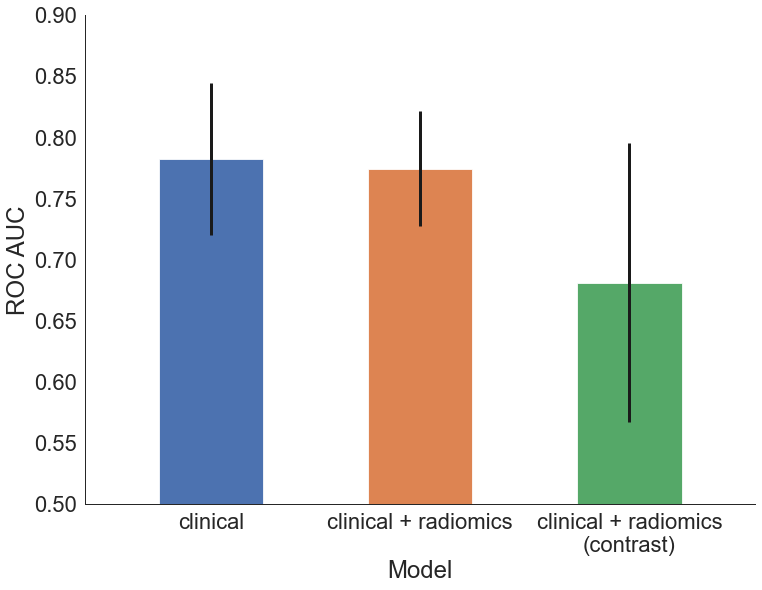

In [49]:
means_stds = scores.groupby('model').agg(['mean', 'std']).droplevel(axis=1, level=0).reset_index()
plt.bar([0, .5, 1.], 'mean', data=means_stds, width=.25, color=['C0', 'C1', 'C2'])
plt.xlim(-.3, 1.3)
plt.ylim(.5, .9)
plt.errorbar([0, .5, 1.], 'mean', yerr='std', data=means_stds, ls='none', c='k', elinewidth=3)
plt.xticks([0, .5, 1.], labels=means_stds['model'])
plt.xlabel('Model')
plt.ylabel('ROC AUC')
sns.despine()

In [65]:
def generate_cv_roc_curve(X, y, estimators, num_folds=5):
  cv = StratifiedKFold(n_splits=num_folds)
  tprs = []
  mean_fpr = np.linspace(0, 1, 100)
  for (train, test), estimator in zip(cv.split(X, y), estimators):
    y_pred = estimator.predict_proba(X.iloc[test])[:, 1]
    fpr, tpr, _ = roc_curve(y[test], y_pred)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  return mean_fpr, mean_tpr

In [66]:
fpr_clinical, tpr_clinical = generate_cv_roc_curve(
  X_clinical,
  clinical['target'].values, 
  results_clinical['estimator'], 
  num_folds,
)
fpr_radiomics, tpr_radiomics = generate_cv_roc_curve(
  X_combined,
  clinical.loc[X_combined.index, 'target'].values, 
  results_radiomics['estimator'],
  num_folds,
)
fpr_radiomics_contrast, tpr_radiomics_contrast = generate_cv_roc_curve(
  X_combined_contrast, 
  clinical.loc[X_combined_contrast.index, 'target'].values,
  results_radiomics_contrast['estimator'],
  num_folds,
)

In [74]:
auc_clinical = scores.loc[scores['model'] == 'clinical', 'score'].mean()
auc_radiomics = scores.loc[scores['model'] == 'clinical + radiomics', 'score'].mean()
auc_radiomics_contrast = scores.loc[scores['model'] == 'clinical + radiomics\n(contrast)', 'score'].mean()

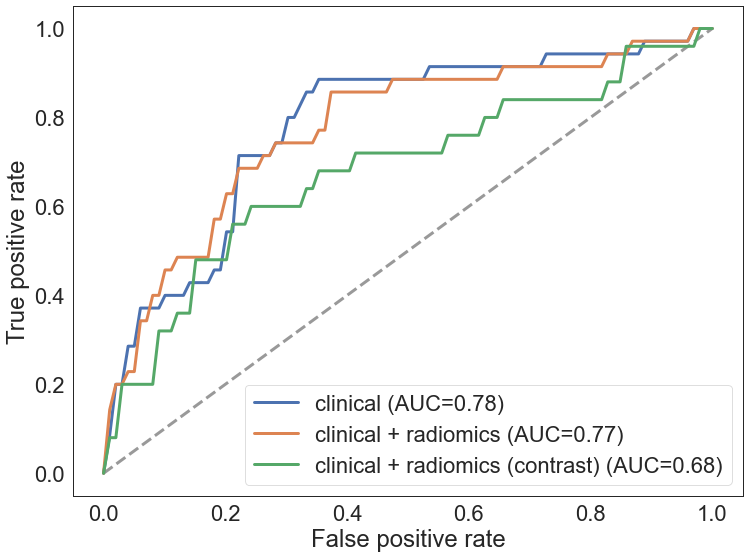

In [78]:
plt.plot([0, 1], [0, 1], linestyle="--", lw=3, color="gray", alpha=0.8)
plt.plot(fpr_clinical, tpr_clinical, label=f'clinical (AUC={auc_clinical:0.2f})', lw=3)
plt.plot(fpr_radiomics, tpr_radiomics, label=f'clinical + radiomics (AUC={auc_radiomics:0.2f})', lw=3)
plt.plot(fpr_radiomics_contrast, tpr_radiomics_contrast, label=f'clinical + radiomics (contrast) (AUC={auc_radiomics_contrast:0.2f})', lw=3)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()